In [1]:
import os, sys
from pathlib import Path

_root = next((p for p in [Path(os.getcwd()), *Path(os.getcwd()).parents]
              if p.name == 'cryptoTrading2'), None)
if _root:
    os.chdir(str(_root))
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

from files.functions import (
    base_dir,
    fullDataPath,
    dataSetup,
    trainingCols,
    normalize_data,
    create_sequences,
    _get_device,
    _transformer_param_grid,
    _torch_train,
    _seq_future_forecast_torch,
    _standardized_rmse,
    _save_model_artifact,
    _save_validation_predictions,
    _save_future_predictions,
    _save_metrics,
)
from files.CONSTANTS import COIN, RESPONSE_VARIABLE, TRAINING_COLUMNS, TEST_DAYS, TRAIN_PCT, LIMIT
from implementations.transformer_model import CryptoTransformer

# Transformer Training

CryptoTransformer — a Transformer encoder with sinusoidal positional encoding and multi-head
self-attention for multivariate crypto price prediction using PyTorch.
This notebook tunes embedding dimension (`d_model`), number of attention heads (`nhead`),
encoder depth, feedforward dimension, and dropout. Only configurations where
`d_model % nhead == 0` are valid and included in the search.

Dataset shape: (730, 25)
Features (23): ['open', 'high', 'low', 'volume', 'value', 'SMA_7', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'EMA_20', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_STD', 'Volume_MA_7', 'OBV', 'avg_sentiment']
Date range: 2024-02-24 00:00:00 → 2026-02-22 00:00:00

data_full shape: (730, 24)  (features + target)


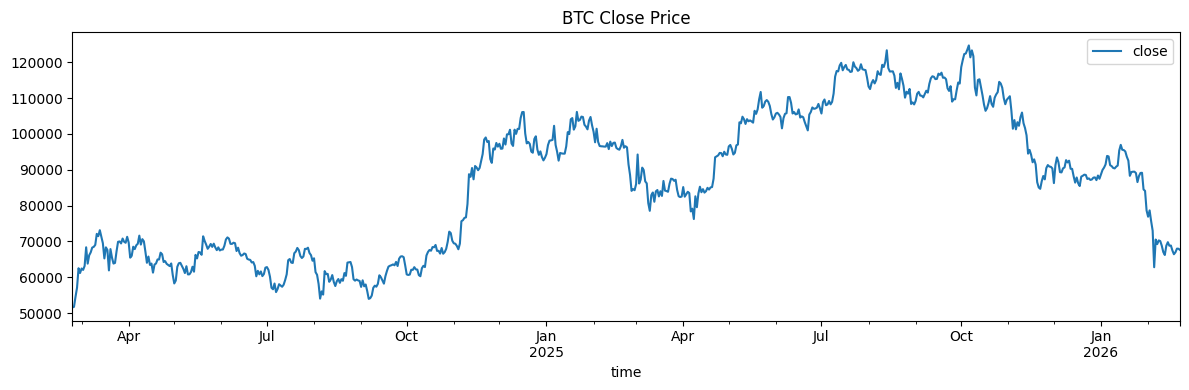


Sequence length: 30
Train sequences: 560  |  Val sequences: 140
Input features: 24
Device: mps


In [2]:
# ── Step 1: Load and Prepare Data ────────────────────────────────────────────
SEQ_LEN = 30
SCALER_METHOD = 'minmax'  # default scaler

raw_path = fullDataPath(COIN)
data = pd.read_csv(raw_path)
daily_data = dataSetup(data, trainingColPath=TRAINING_COLUMNS, response=RESPONSE_VARIABLE, number=LIMIT)
cols = trainingCols(TRAINING_COLUMNS)
data_full = daily_data[cols + [RESPONSE_VARIABLE]].copy()
print(f"Dataset shape: {daily_data.shape}")
print(f"Features ({len(cols)}): {cols}")
print(f"Date range: {daily_data.index[0]} → {daily_data.index[-1]}")
print(f"\ndata_full shape: {data_full.shape}  (features + target)")

daily_data[[RESPONSE_VARIABLE]].plot(title=f"{COIN} Close Price", figsize=(12, 4))
plt.tight_layout()
plt.show()

# Normalize with default scaler
scaled_data, feat_sc, tgt_sc = normalize_data(
    data_full, method=SCALER_METHOD, target_col=RESPONSE_VARIABLE
)

# ── Step 2: Create Sequences and Train/Val Split ──────────────────────────────
X_seq, y_seq = create_sequences(scaled_data, sequence_length=SEQ_LEN, prediction_horizon=1)
n_train = max(1, int(len(X_seq) * TRAIN_PCT))

X_tr = torch.tensor(X_seq[:n_train], dtype=torch.float32)
y_tr = torch.tensor(y_seq[:n_train].flatten(), dtype=torch.float32)
X_va = torch.tensor(X_seq[n_train:], dtype=torch.float32)
y_va_np = y_seq[n_train:].flatten()
y_va_t = torch.tensor(y_va_np, dtype=torch.float32)

num_features = X_tr.shape[2]
device = _get_device()
print(f"\nSequence length: {SEQ_LEN}")
print(f"Train sequences: {len(X_tr)}  |  Val sequences: {len(X_va)}")
print(f"Input features: {num_features}")
print(f"Device: {device}")

In [3]:
# ── Step 3: Define Hyperparameter Grid ───────────────────────────────────────
# Only keep configs where d_model % nhead == 0 (required by MultiheadAttention)
full_grid = _transformer_param_grid()
param_grid = [cfg for cfg in full_grid if cfg['d_model'] % cfg['nhead'] == 0]

print(f"Full grid size:   {len(full_grid)} configs")
print(f"Valid grid size:  {len(param_grid)} configs  (d_model % nhead == 0)")
print("\nValid configs:")
for cfg in param_grid:
    print(" ", cfg)

Full grid size:   16 configs
Valid grid size:  16 configs  (d_model % nhead == 0)

Valid configs:
  {'d_model': 32, 'dim_feedforward': 128, 'dropout': 0.1, 'nhead': 2, 'num_encoder_layers': 1}
  {'d_model': 32, 'dim_feedforward': 128, 'dropout': 0.1, 'nhead': 2, 'num_encoder_layers': 2}
  {'d_model': 32, 'dim_feedforward': 128, 'dropout': 0.1, 'nhead': 4, 'num_encoder_layers': 1}
  {'d_model': 32, 'dim_feedforward': 128, 'dropout': 0.1, 'nhead': 4, 'num_encoder_layers': 2}
  {'d_model': 32, 'dim_feedforward': 256, 'dropout': 0.1, 'nhead': 2, 'num_encoder_layers': 1}
  {'d_model': 32, 'dim_feedforward': 256, 'dropout': 0.1, 'nhead': 2, 'num_encoder_layers': 2}
  {'d_model': 32, 'dim_feedforward': 256, 'dropout': 0.1, 'nhead': 4, 'num_encoder_layers': 1}
  {'d_model': 32, 'dim_feedforward': 256, 'dropout': 0.1, 'nhead': 4, 'num_encoder_layers': 2}
  {'d_model': 64, 'dim_feedforward': 128, 'dropout': 0.1, 'nhead': 2, 'num_encoder_layers': 1}
  {'d_model': 64, 'dim_feedforward': 128, 'drop

In [4]:
# ── Step 4: Tune Hyperparameters ─────────────────────────────────────────────
best_score = np.inf
best_combo = None
tuning_results = []

print("Running Transformer hyperparameter search...")
for params in param_grid:
    # Guard: skip if d_model % nhead != 0 (should already be filtered)
    if params['d_model'] % params['nhead'] != 0:
        print(f"  SKIPPED (d_model={params['d_model']} % nhead={params['nhead']} != 0): {params}")
        continue
    try:
        m = CryptoTransformer(num_features=num_features, **params)
        m, val_loss = _torch_train(
            m, X_tr, y_tr, X_va, y_va_t,
            lr=1e-3, epochs=30, batch_size=32, patience=5, device=device
        )
        rec = {**params, 'val_loss': val_loss}
        tuning_results.append(rec)
        if val_loss < best_score:
            best_score = val_loss
            best_combo = rec.copy()
        print(f"  d_model={params['d_model']} nhead={params['nhead']} "
              f"layers={params['num_encoder_layers']} ff={params['dim_feedforward']}  "
              f"val_loss={val_loss:.6f}")
    except Exception as e:
        print(f"  ERROR {params}: {e}")

if best_combo is None:
    best_combo = {'d_model': 64, 'nhead': 4, 'num_encoder_layers': 2,
                  'dim_feedforward': 256, 'dropout': 0.1, 'val_loss': np.nan}
    print("WARNING: No valid config found; using defaults.")

print(f"\nBest combo: {best_combo}")

tuning_df = pd.DataFrame(tuning_results).sort_values('val_loss').reset_index(drop=True)
print("\nTop-5 tuning results:")
print(tuning_df.head(5).to_string(index=False))

Running Transformer hyperparameter search...
  d_model=32 nhead=2 layers=1 ff=128  val_loss=0.003734
  d_model=32 nhead=2 layers=2 ff=128  val_loss=0.003599
  d_model=32 nhead=4 layers=1 ff=128  val_loss=0.004375
  d_model=32 nhead=4 layers=2 ff=128  val_loss=0.002009
  d_model=32 nhead=2 layers=1 ff=256  val_loss=0.002843
  d_model=32 nhead=2 layers=2 ff=256  val_loss=0.002778
  d_model=32 nhead=4 layers=1 ff=256  val_loss=0.002027
  d_model=32 nhead=4 layers=2 ff=256  val_loss=0.003643
  d_model=64 nhead=2 layers=1 ff=128  val_loss=0.002019
  d_model=64 nhead=2 layers=2 ff=128  val_loss=0.001893
  d_model=64 nhead=4 layers=1 ff=128  val_loss=0.004972
  d_model=64 nhead=4 layers=2 ff=128  val_loss=0.003228
  d_model=64 nhead=2 layers=1 ff=256  val_loss=0.001924
  d_model=64 nhead=2 layers=2 ff=256  val_loss=0.002420
  d_model=64 nhead=4 layers=1 ff=256  val_loss=0.003864
  d_model=64 nhead=4 layers=2 ff=256  val_loss=0.002902

Best combo: {'d_model': 64, 'dim_feedforward': 128, 'dropo

In [5]:
# ── Step 5: Train Best Model ──────────────────────────────────────────────────
best_hp = {k: v for k, v in best_combo.items() if k != 'val_loss'}
print(f"Training final Transformer with: {best_hp}")

best_model = CryptoTransformer(num_features=num_features, **best_hp)
best_model, final_val_loss = _torch_train(
    best_model, X_tr, y_tr, X_va, y_va_t,
    lr=1e-3, epochs=50, batch_size=32, patience=10, device=device
)
best_model.eval()
print(f"Final val loss: {final_val_loss:.6f}")

Training final Transformer with: {'d_model': 64, 'dim_feedforward': 128, 'dropout': 0.1, 'nhead': 2, 'num_encoder_layers': 2}
Final val loss: 0.003017


In [6]:
# ── Step 6: Save Model to models/{COIN}/ ─────────────────────────────────────
_models_dir = os.path.join(base_dir(), 'models', COIN)
os.makedirs(_models_dir, exist_ok=True)
model_pt_path = os.path.join(_models_dir, f'{COIN}_transformer_model.pt')
torch.save(best_model.state_dict(), model_pt_path)
print(f"Model state dict saved to: {model_pt_path}")

meta_path = _save_model_artifact(
    {'feat_scaler': feat_sc, 'tgt_scaler': tgt_sc, 'params': best_combo,
     'seq_len': SEQ_LEN, 'scaler_method': SCALER_METHOD},
    COIN,
    f'{COIN}_transformer_meta.pkl'
)
print(f"Meta artifact saved to: {meta_path}")

Model state dict saved to: /Users/sucheen/Documents/cryptoTrading2/models/BTC/BTC_transformer_model.pt
Meta artifact saved to: /Users/sucheen/Documents/cryptoTrading2/models/BTC/BTC_transformer_meta.pkl


Validation RMSE:            4,017.62
Standardized RMSE (÷ std):  0.2931


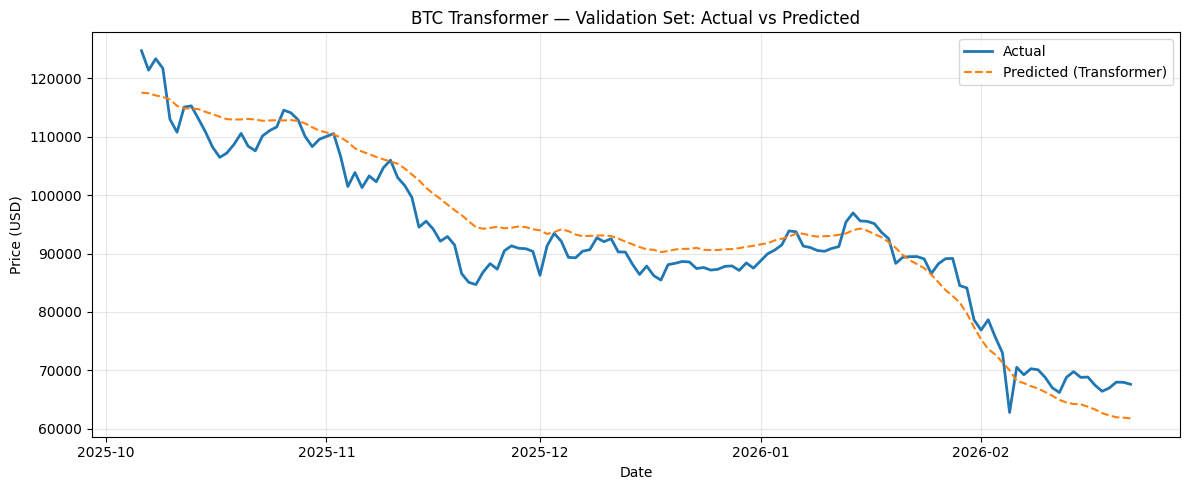

In [7]:
# ── Step 7: Predict on Validation Set ────────────────────────────────────────
best_model.eval()
with torch.no_grad():
    val_preds_scaled = best_model(X_va).squeeze(-1).numpy()

# Inverse-transform to price scale
val_preds = tgt_sc.inverse_transform(val_preds_scaled.reshape(-1, 1)).flatten()
val_true = tgt_sc.inverse_transform(y_va_np.reshape(-1, 1)).flatten()

# Align with daily_data index
val_idx = daily_data.index[n_train + SEQ_LEN: n_train + SEQ_LEN + len(val_preds)]
val_df = pd.DataFrame({'predicted_price': val_preds}, index=val_idx[:len(val_preds)])

# Compute RMSE
rmse = float(np.sqrt(np.mean((val_true - val_preds) ** 2)))
std_rmse = rmse / float(np.std(val_true)) if float(np.std(val_true)) > 0 else rmse
print(f"Validation RMSE:            {rmse:,.2f}")
print(f"Standardized RMSE (÷ std):  {std_rmse:.4f}")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(val_idx[:len(val_true)], val_true, label='Actual', linewidth=2)
ax.plot(val_df.index, val_df['predicted_price'], label='Predicted (Transformer)', linestyle='--')
ax.set_title(f"{COIN} Transformer — Validation Set: Actual vs Predicted")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Future predictions for next 7 days:
            predicted_price
2026-02-23     61605.244438
2026-02-24     61313.870169
2026-02-25     61168.570533
2026-02-26     61039.851063
2026-02-27     60946.716112
2026-02-28     60898.766502
2026-03-01     60878.799670


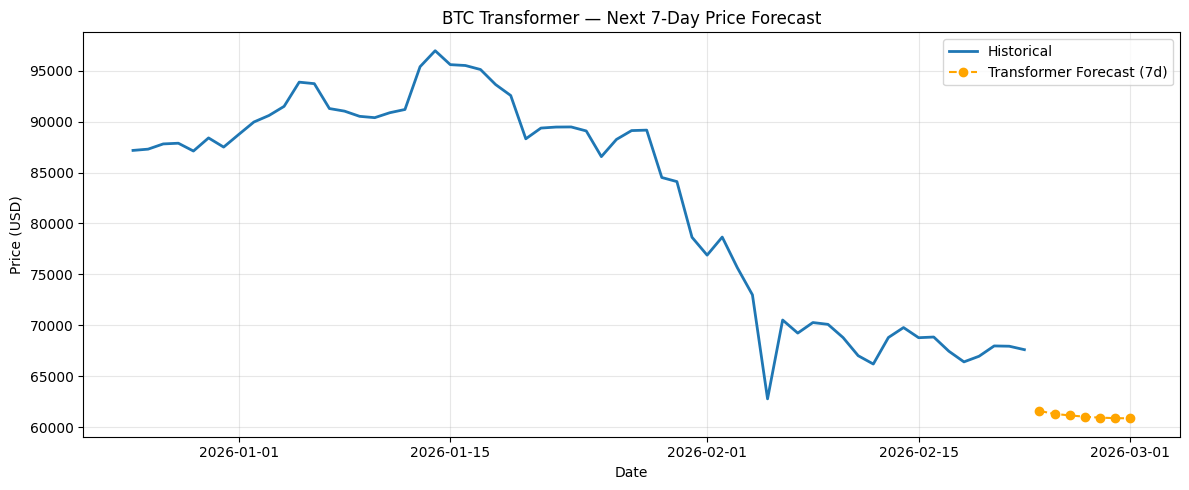

In [8]:
# ── Step 8: Predict Next TEST_DAYS Days ──────────────────────────────────────
future_df = _seq_future_forecast_torch(
    best_model, scaled_data, SEQ_LEN, tgt_sc, daily_data, n=TEST_DAYS
)

print(f"Future predictions for next {TEST_DAYS} days:")
print(future_df.to_string())

# Plot future forecast
fig, ax = plt.subplots(figsize=(12, 5))
hist = daily_data[RESPONSE_VARIABLE].iloc[-60:]
ax.plot(hist.index, hist.values, label='Historical', linewidth=2)
ax.plot(future_df.index, future_df['predicted_price'], marker='o',
        linestyle='--', label=f'Transformer Forecast ({TEST_DAYS}d)', color='orange')
ax.set_title(f"{COIN} Transformer — Next {TEST_DAYS}-Day Price Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# ── Step 9: Save Predictions and Metrics ─────────────────────────────────────
val_path = _save_validation_predictions(val_df, COIN, 'transformer')
future_path = _save_future_predictions(future_df, COIN, 'transformer')
metrics_path = _save_metrics(std_rmse, COIN, 'transformer')

print(f"Validation predictions saved to: {val_path}")
print(f"Future predictions saved to:     {future_path}")
print(f"Metrics (std RMSE) saved to:     {metrics_path}")
print(f"\nStandardized RMSE: {std_rmse:.4f}")
print("Done.")

Validation predictions saved to: /Users/sucheen/Documents/cryptoTrading2/predictions/BTCtransformer_validation_predictions.csv
Future predictions saved to:     /Users/sucheen/Documents/cryptoTrading2/predictions/BTCtransformer_future_predictions.csv
Metrics (std RMSE) saved to:     /Users/sucheen/Documents/cryptoTrading2/metrics/BTC/transformer_rmse.txt

Standardized RMSE: 0.2931
Done.
